In [1]:
from sism.datasets import generate_samples_from_3d_torus, generate_samples_from_3d_sphere, generate_mog_3d
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
from IPython.display import display, clear_output
import math
import numpy as np
from typing import Tuple
import matplotlib.cm as cm
import math

/Users/tuanle/Desktop/projects/symmetry-induced-score-matching/sism/datasets.py:120: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987091277/work/aten/src/ATen/native/TensorShape.cpp:3641.)
  rotated_mean = (R @ mean.T).T


In [2]:
import torch
import torch.nn as nn
figsize = (6, 6)

In [3]:
class SO3Prior:
    def __init__(self, std_r=1, std_theta=1):
        self.std_r = std_r
        self.std_theta = std_theta
        self.log_r_d = torch.distributions.Normal(0, 1)
        self.theta_d = torch.distributions.Normal(0, 1)
        
    def sample(self, n):
        r = torch.exp(self.log_r_d.sample((n,)) * self.std_r)
        theta = self.theta_d.sample((n,)) * self.std_theta
        phi = self.theta_d.sample((n,)) * self.std_theta
        return torch.stack([r, theta, phi], dim=-1)

In [4]:
x = torch.randn(1, 3)

In [5]:
I = torch.eye(3).float().unsqueeze(0)
Ax = torch.tensor([[0, 0, 0],
                   [0, 0, -1],
                   [0, 1, 0]]).float().unsqueeze(0)
Ay = torch.tensor([[0, 0, 1],
                   [0, 0, 0],
                   [-1, 0, 0]]).float().unsqueeze(0)
Az = torch.tensor([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 0]]).float().unsqueeze(0)

ex = torch.tensor([1,0,0]).float().unsqueeze(0)
ey = torch.tensor([0,1,0]).float().unsqueeze(0)
ez = torch.tensor([0,0,1]).float().unsqueeze(0)

In [6]:
Ax @ Ax

tensor([[[ 0.,  0.,  0.],
         [ 0., -1.,  0.],
         [ 0.,  0., -1.]]])

In [7]:
Ay @ Ax

tensor([[[0., 1., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [8]:
Ax @ Ay

tensor([[[0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.]]])

In [9]:
Ay @ Ay

tensor([[[-1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0., -1.]]])

In [10]:
phi = 0.0
# phi = arc tan (y/x)
cosphi =  math.cos(phi)
sinphi = math.sin(phi)
A_theta=  cosphi * Ay - sinphi * Ax

A_theta

tensor([[[ 0.,  0.,  1.],
         [ 0.,  0.,  0.],
         [-1.,  0.,  0.]]])

In [11]:
print(cosphi, sinphi)

1.0 0.0


In [12]:
torch.matmul(A_theta, A_theta)

tensor([[[-1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0., -1.]]])

In [13]:
A_theta = 1 * Ay - 1 * Ax


In [14]:
torch.matmul(I, I) + torch.matmul(A_theta, A_theta) + torch.matmul(Az, Az)

tensor([[[-1., -1.,  0.],
         [-1., -1.,  0.],
         [ 0.,  0., -1.]]])

In [15]:
torch.matmul(A_theta, A_theta)

tensor([[[-1., -1.,  0.],
         [-1., -1.,  0.],
         [ 0.,  0., -2.]]])

In [16]:
torch.matmul(Az, Az)

tensor([[[-1.,  0.,  0.],
         [ 0., -1.,  0.],
         [ 0.,  0.,  0.]]])

In [17]:
print(cosphi, sinphi)

1.0 0.0


In [18]:
torch.matmul(A_theta, A_theta) + torch.matmul(Az, Az) + torch.matmul(I, I)

tensor([[[-1., -1.,  0.],
         [-1., -1.,  0.],
         [ 0.,  0., -1.]]])

In [19]:
torch.matmul(Az, Az)

tensor([[[-1.,  0.,  0.],
         [ 0., -1.,  0.],
         [ 0.,  0.,  0.]]])

In [20]:
def vector_to_skew_matrix(x, Ax, Ay, Az):
        """_summary_
        Computes the skew-form of a vector.
        I.e. transforming a vector into a lie algebra element of SO(3) by left multiplication with the basis matrices.
        """
        skew = (x[:, 0].unsqueeze(-1).unsqueeze(-1) * Ax + x[:, 1].unsqueeze(-1).unsqueeze(-1) * Ay + x[:, 2].unsqueeze(1).unsqueeze(-1) * Az)
        return skew

def rodrigues_formula_skew(S: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    """_summary_
    Computes the exponential map of a skew-symmetric matrix using the Rodrigues formula.
    """
    assert S.shape[-1] == 3
    assert S.shape[-2] == 3
    O = I + torch.sin(theta) * S + (1 - torch.cos(theta)) * S.matmul(S)
    return O

In [21]:
def to_cartesian(input):
    if input.dim() == 1:
        input = input.unsqueeze(dim=0)
    r, theta, phi = input.chunk(3, dim=1)
    x = r * torch.sin(theta) * torch.cos(phi)
    y = r * torch.sin(theta) * torch.sin(phi)
    z = r * torch.cos(theta)
    return torch.concat([x, y, z], dim=1)

def to_spherical(input):
    if input.dim() == 1:
        input = input.unsqueeze(dim=0)
    x, y, z = input.chunk(3, dim=1)
    r = torch.sqrt(x**2 + y**2 + z**2)
    theta = torch.atan2((x**2 + y**2)**0.5, z)
    phi = torch.atan2(y, x)
    return torch.concat([r, theta, phi], dim=1)

In [22]:
def forward_noising_vp(input: torch.Tensor,
                       s: torch.Tensor,
                       m: torch.Tensor,
                       sqrt: bool = False,
                       ) -> Tuple[torch.Tensor, torch.Tensor]:
    
    if s.ndim == 1:
        s = s.unsqueeze(1)
    if m.ndim == 1:
        m = m.unsqueeze(1)
    
    r, theta, phi = to_spherical(input).chunk(3, dim=1)
    r_n, theta_n, phi_n = torch.randn_like(r), torch.randn_like(theta), torch.randn_like(phi)
    if sqrt:
        m = m.sqrt()
    rt = m * r.log() + s * r_n
    tt = m * theta + s * theta_n
    pt = m * phi + s * phi_n
    
    input = torch.concat([rt.exp(), tt, pt], dim=1)
    xt = to_cartesian(input)
    l = torch.concat([r_n, theta_n, phi_n], dim=1)
    return xt, l

In [23]:
T = 100
def get_diffusion_coefficients(T, kind="linear-time", alpha_clip_min=0.001):
    if kind == "linear-time":
        t = np.linspace(1e-3, 1.0, T + 2)
        alphas_cumprod = 1.0 - t
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        betas = 1 - alphas
        betas = np.clip(betas, 0.0, 1.0 - alpha_clip_min)
        betas = torch.from_numpy(betas).float().squeeze()
    elif kind == "cosine":
        s = 0.008
        steps = T + 2
        x = torch.linspace(0, T, steps)
        alphas_cumprod = (
            torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5)
            ** 2
        )
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        alphas = alphas.clip(min=alpha_clip_min)
        betas = 1 - alphas
        betas = torch.clip(betas, 0.0, 1.0 - alpha_clip_min).float()
    elif kind == "ddpm":
        betas = torch.linspace(0.1 / T, 20 / T, T + 1)
    return betas

In [24]:
T = 100
betas = get_diffusion_coefficients(T, kind="cosine")

In [25]:
alpha = 1.0 - betas
mean_coeff = alpha.cumprod(dim=0)
std_coeff = (1.0 - mean_coeff).sqrt()

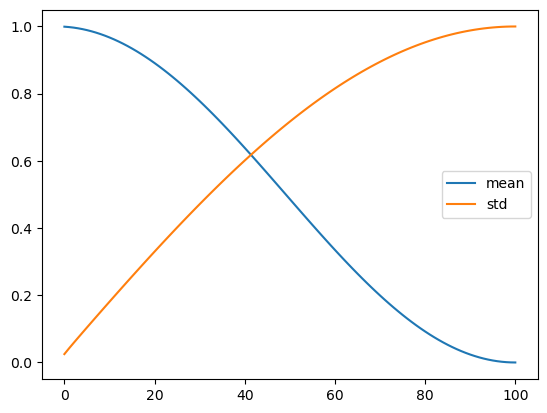

In [26]:
plt.plot(range(T+1), mean_coeff, label="mean")
plt.plot(range(T+1), std_coeff, label="std")
plt.legend()
plt.show()

In [27]:
def get_dataset(mode="mog"):
    if mode == "mog":
        mog = True
        torus = False
    elif mode == "torus":
        mog = False
        torus = True
    else:
        raise ValueError("mode must be either 'mog' or 'torus'")

    if mog:
        dataset, gmm = generate_mog_3d(10_000)
        dataset = dataset - dataset.mean(0,keepdim=True)
    else:
        dataset = generate_samples_from_3d_torus(nsamples=10_000, R=3., r=1.)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2)

    device = torch.device("cpu")
    if isinstance(dataset, np.ndarray):
        x = torch.from_numpy(dataset).float()
    else:
        x = dataset.clone()

    ids = np.arange(len(dataset))
    torch_dataset = x.clone().to(device)
    if torus:
        ax.view_init(30, 26)
        ax.set_zlim(-3, 3)
    plt.show()
    
    return ids, x, torch_dataset, dataset, mog, torus

# Experiments on Mixture of Gaussians

tensor([[ 5.7807,  4.4619, -1.4922],
        [ 1.3188, -2.2744,  3.2350],
        [ 2.4024,  5.0419,  1.0676],
        [-2.0599,  1.8314,  4.0042],
        [-0.6949,  0.1253, -0.7547],
        [ 2.5796, -0.9292, -1.1871]])


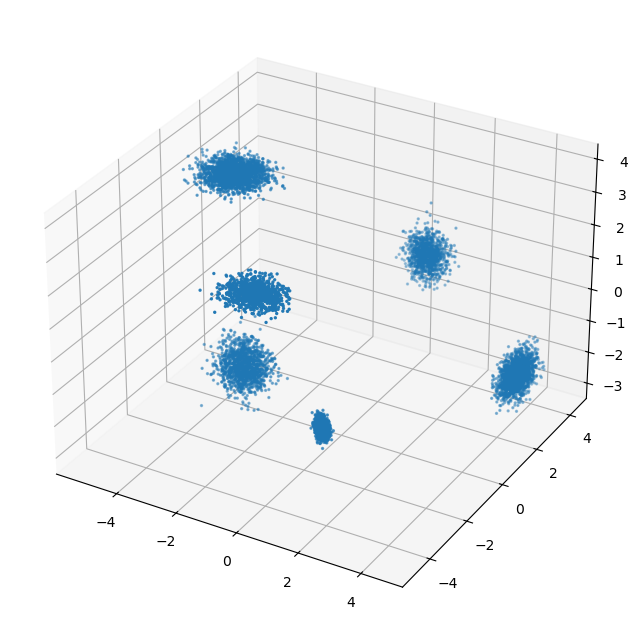

In [28]:
ids, x, torch_dataset, dataset, mog, torus = get_dataset("mog")
bs = 128

  0%|          | 0/1000 [00:00<?, ?epoch/s]

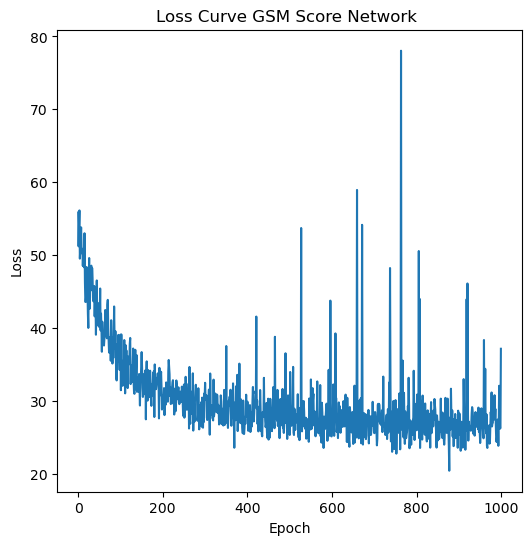

In [29]:
in_dim = 3
hidden_dim = 32
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            xt, target = forward_noising_vp(input=xin, m=signal, s=std, sqrt=True)
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve GSM Score Network ")
plt.show()

#### Sampling with generalized scores
Since we implement the dynamics with dilation and 3D rotations in $\mathbb{R}^3$, the scores contribute to a radial and angular part.
For sampling, you can set either `r_dynamic`, `theta_dynamic`, `phi_dynamic` to `False` to see how the trajectory can be decomposed.

  0%|          | 0/100 [00:00<?, ?it/s]

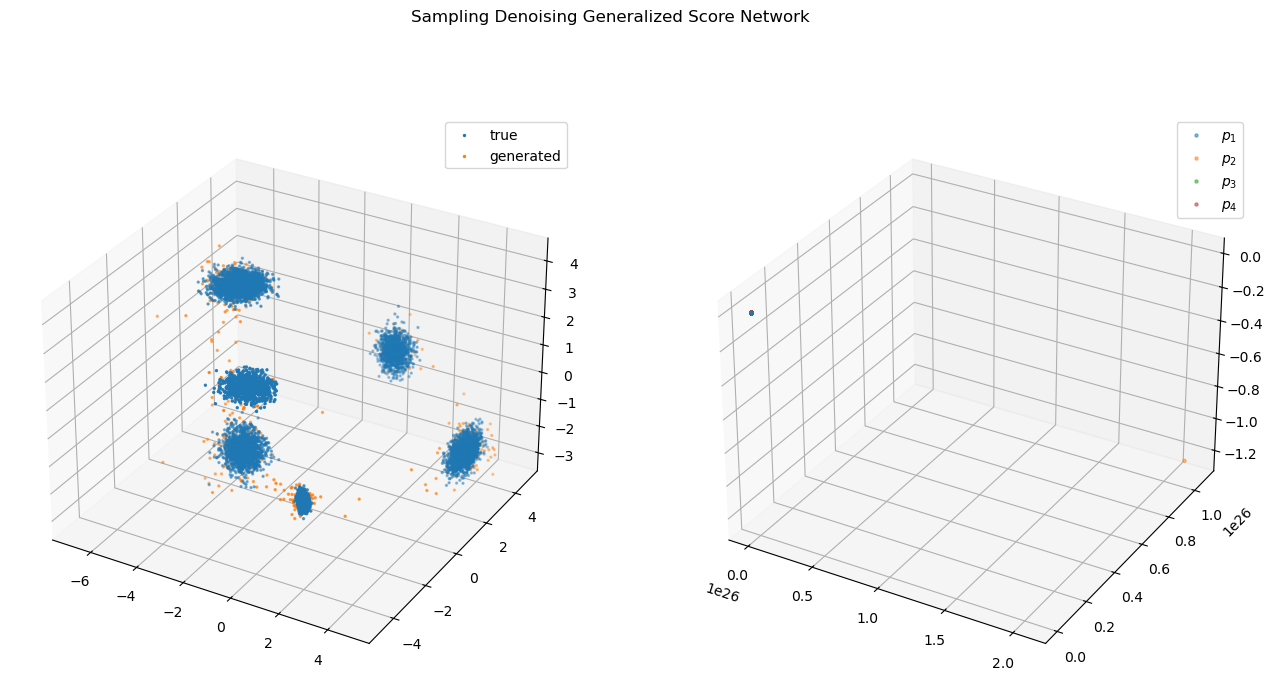

In [32]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi_dynamic = True

prior = SO3Prior()  

assert (sum((r_dynamic, theta_dynamic, phi_dynamic)) > 0)

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):  
        t_ = torch.tensor([t] * num_samples)
        
        beta = betas[t_].unsqueeze(-1)
        temb = (t_ / T).unsqueeze(-1)
        score = score_net(torch.concat([xsampled, temb], dim=-1))
        
        r, theta, phi = to_spherical(xsampled).chunk(3, dim=1)
        
        # radius: drift and score
        d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
        
        A_theta = torch.concat([
            -torch.sin(phi),
            torch.cos(phi),
            torch.zeros_like(phi),
        ], dim=-1)
            
        A_theta = vector_to_skew_matrix(A_theta, Ax, Ay, Az)
        # theta: drift and score
        d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        # phi: drift and score
        d_phi =(0.5 * phi + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Az, xsampled))

        noise = torch.randn_like(score)
        nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
        n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled)) 
        n_phi = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Az, xsampled))
                
        if r_dynamic:
            x_update = xsampled + beta * d_r
        else:
            x_update = xsampled
            
        if theta_dynamic:
            x_update = x_update + beta * d_theta
                            
        if phi_dynamic:
            x_update = x_update + beta * d_phi
            
        if stochastic:
            # noise term + casimir invariant terms + divergence term
            if r_dynamic:
                x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled  + 0.5 * beta * xsampled
            if theta_dynamic:
                tmp = xsampled.clone()
                z = (tmp[:, -1]).clone()
                tmp[:, -1] = 0.0
                xysq = tmp.pow(2).sum(-1).sqrt()
                coeff = z / xysq.clamp_min(1e-2)
                div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
                x_update = x_update + beta.sqrt() * n_theta  - 0.5 * beta * xsampled  + beta * div
            if phi_dynamic:
                tmp = xsampled.clone()
                tmp[:, -1] = 0.0
                x_update = x_update + beta.sqrt() * n_phi  - 0.5 * beta * tmp + 0.0 

                
        xsampled = x_update                        
        x_traj.append(xsampled)
        
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
if torus:
    ax.view_init(30, 26)
    ax.set_zlim(-3, 3)
    
plt.legend()

traj_1 = torch.stack(x_traj)[:, -1, :].detach()
traj_2 = torch.stack(x_traj)[:, -2, :].detach()
traj_3 = torch.stack(x_traj)[:, -3, :].detach()
traj_4 = torch.stack(x_traj)[:, -4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Generalized Score Network")
plt.show()

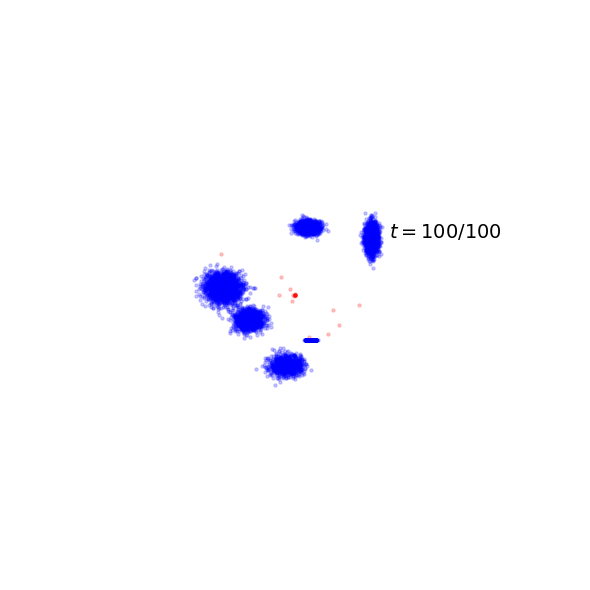

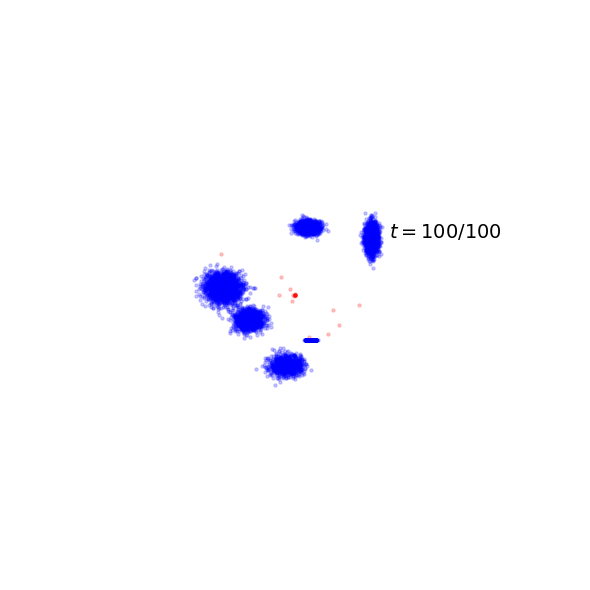

In [33]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi_dynamic = True

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

x_traj = []
xnumpy = x.detach().cpu()

fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
            
            r, theta, phi = to_spherical(xsampled).chunk(3, dim=1)
            
            
            d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
            
            A_theta = torch.concat([
                -torch.sin(phi),
                torch.cos(phi),
                torch.zeros_like(phi),
            ], dim=-1)


            A_theta = vector_to_skew_matrix(A_theta, Ax, Ay, Az)
            d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1))* torch.einsum('bij, bj -> bi', (A_theta, xsampled))
            
            d_phi =(0.5 * phi + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Az, xsampled))

            noise = torch.randn_like(score)
            nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
            n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
            n_phi = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Az, xsampled))
            
            
            if r_dynamic:
                xsampled = xsampled + beta * d_r
            if theta_dynamic:
                xsampled = xsampled + beta * d_theta
            if phi_dynamic:
                xsampled = xsampled + beta * d_phi
             
            if stochastic:
                # noise term + casimir invariant terms + divergence term
                if r_dynamic:
                    x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled  + 0.5 * beta * xsampled
                if theta_dynamic:
                    tmp = xsampled.clone()
                    z = (tmp[:, -1]).clone()
                    tmp[:, -1] = 0.0
                    xysq = tmp.pow(2).sum(-1).sqrt()
                    coeff = z / xysq.clamp_min(1e-2)
                    div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
                    x_update = x_update + beta.sqrt() * n_theta  - 0.5 * beta * xsampled  + beta * div
                if phi_dynamic:
                    tmp = xsampled.clone()
                    tmp[:, -1] = 0.0
                    x_update = x_update + beta.sqrt() * n_phi  - 0.5 * beta * tmp + 0.0 
        
                
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        clear_output(wait=True)
        display(fig)
        x_traj.append(xsampled)


In [ ]:
in_dim = 3
hidden_dim = 32
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            noise = torch.randn_like(xin)
            xt = signal.sqrt() * xin + std * noise
            target = noise
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Fisher Score Network ")
plt.show()

In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

xsampled = torch.randn(num_samples, in_dim) * 1.0

x_traj = []
xnumpy = x.detach().cpu()

fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
        
            xsampled = xsampled + 0.5 * beta * xsampled
            xsampled = xsampled + beta * score
            
            if stochastic: 
                xsampled = xsampled + beta.sqrt() * torch.randn_like(xsampled)
            
            x_traj.append(xsampled)
            time_text.set_text(f'$t={i+1} / {T}$')
            scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
            clear_output(wait=True)
            display(fig)
        x_traj.append(xsampled)


In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

xsampled = torch.randn(num_samples, in_dim) * 1.0

x_traj = []
xnumpy = x.detach().cpu()

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
        
            # xsampled = (2.0 - (1.0 - beta).sqrt()) * xsampled + beta * score
            xsampled = xsampled + 0.5 * beta * xsampled
            xsampled = xsampled + beta * score
            #xsampled = 1 / (1.0 - beta).sqrt() * (xsampled + beta * score)
            
            if stochastic: 
                xsampled = xsampled + beta.sqrt() * torch.randn_like(xsampled)
        x_traj.append(xsampled)

     
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
if torus:
    ax.view_init(30, 26)
    ax.set_zlim(-3, 3)
plt.legend()

traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Fisher Score Network")
plt.show()


# Experiments on Torus

In [ ]:
ids, x, torch_dataset, dataset, mog, torus = get_dataset("torus")
bs = 128

In [ ]:
in_dim = 3
hidden_dim = 32
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            xt, target = forward_noising_vp(input=xin, m=signal, s=std, sqrt=True)
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve GSM Score Network ")
plt.show()

#### Sampling with generalized scores
Since we implement the dynamics with dilation and 3D rotations in $\mathbb{R}^3$, the scores contribute to a radial and angular part.
For sampling, you can set either `r_dynamic`, `theta_dynamic`, `phi_dynamic` to `False` to see how the trajectory can be decomposed.

In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi_dynamic = True

prior = SO3Prior()  

assert (sum((r_dynamic, theta_dynamic, phi_dynamic)) > 0)

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):  
        t_ = torch.tensor([t] * num_samples)
        
        beta = betas[t_].unsqueeze(-1)
        temb = (t_ / T).unsqueeze(-1)
        score = score_net(torch.concat([xsampled, temb], dim=-1))
        
        r, theta, phi = to_spherical(xsampled).chunk(3, dim=1)
        
        # radius: drift and score
        d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
        
        A_theta = torch.concat([
            -torch.sin(phi),
            torch.cos(phi),
            torch.zeros_like(phi),
        ], dim=-1)
            
        A_theta = vector_to_skew_matrix(A_theta, Ax, Ay, Az)
        # theta: drift and score
        d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        # phi: drift and score
        d_phi =(0.5 * phi + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Az, xsampled))

        noise = torch.randn_like(score)
        nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
        n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled)) 
        n_phi = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Az, xsampled))
                
        if r_dynamic:
            x_update = xsampled + beta * d_r
        else:
            x_update = xsampled
            
        if theta_dynamic:
            x_update = x_update + beta * d_theta
                            
        if phi_dynamic:
            x_update = x_update + beta * d_phi
            
        if stochastic:
            # noise term + casimir invariant terms + divergence term
            if r_dynamic:
                x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled  # + 3. * beta * xsampled
            if theta_dynamic:
                tmp = xsampled.clone()
                z = (tmp[:, -1]).clone()
                tmp[:, -1] = 0.0
                xysq = tmp.pow(2).sum(-1).sqrt()
                coeff = z / xysq.clamp_min(1e-2)
                div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
                x_update = x_update + beta.sqrt() * n_theta  - 0.5 * beta * xsampled  + beta * div
            if phi_dynamic:
                tmp = xsampled.clone()
                tmp[:, -1] = 0.0
                x_update = x_update + beta.sqrt() * n_phi  - 0.5 * beta * tmp + 0.0 

                
        xsampled = x_update                        
        x_traj.append(xsampled)
        
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
if torus:
    ax.view_init(30, 26)
    ax.set_zlim(-3, 3)
    
plt.legend()

traj_1 = torch.stack(x_traj)[:, -1, :].detach()
traj_2 = torch.stack(x_traj)[:, -2, :].detach()
traj_3 = torch.stack(x_traj)[:, -3, :].detach()
traj_4 = torch.stack(x_traj)[:, -4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Generalized Score Network")
plt.show()

In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi_dynamic = True

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

x_traj = []
xnumpy = x.detach().cpu()

fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
            
            r, theta, phi = to_spherical(xsampled).chunk(3, dim=1)
            
            
            d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
            
            A_theta = torch.concat([
                -torch.sin(phi),
                torch.cos(phi),
                torch.zeros_like(phi),
            ], dim=-1)


            A_theta = vector_to_skew_matrix(A_theta, Ax, Ay, Az)
            d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1))* torch.einsum('bij, bj -> bi', (A_theta, xsampled))
            
            d_phi =(0.5 * phi + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Az, xsampled))

            noise = torch.randn_like(score)
            nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
            n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
            n_phi = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Az, xsampled))
            
            
            if r_dynamic:
                xsampled = xsampled + beta * d_r
            if theta_dynamic:
                xsampled = xsampled + beta * d_theta
            if phi_dynamic:
                xsampled = xsampled + beta * d_phi
             
            if stochastic:
                # noise term + casimir invariant terms + divergence term
                if r_dynamic:
                    xsampled = xsampled + 1/1. * beta.sqrt() * nr + 0.5 * beta * xsampled # + 3. * beta * xsampled
                if theta_dynamic:
                    xsampled = xsampled + 1/1. * beta.sqrt() * n_theta - 0.5 * beta * xsampled 
                if phi_dynamic:
                    tmp = xsampled.clone()
                    tmp[:, -1] = 0.0
                    xsampled = xsampled + 1/1. * beta.sqrt() * n_phi - 0.5 * beta * tmp
                
                
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        clear_output(wait=True)
        display(fig)
        x_traj.append(xsampled)


In [ ]:
in_dim = 3
hidden_dim = 32
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            noise = torch.randn_like(xin)
            xt = signal.sqrt() * xin + std * noise
            target = noise
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Fisher Score Network ")
plt.show()

In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

xsampled = torch.randn(num_samples, in_dim) * 1.0

x_traj = []
xnumpy = x.detach().cpu()

fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
        
            xsampled = xsampled + 0.5 * beta * xsampled
            xsampled = xsampled + beta * score
            
            if stochastic: 
                xsampled = xsampled + beta.sqrt() * torch.randn_like(xsampled)
            
            x_traj.append(xsampled)
            time_text.set_text(f'$t={i+1} / {T}$')
            scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
            clear_output(wait=True)
            display(fig)
        x_traj.append(xsampled)


In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

xsampled = torch.randn(num_samples, in_dim) * 1.0

x_traj = []
xnumpy = x.detach().cpu()

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
        
            xsampled = xsampled + 0.5 * beta * xsampled
            xsampled = xsampled + beta * score
            
            if stochastic: 
                xsampled = xsampled + beta.sqrt() * torch.randn_like(xsampled)
        x_traj.append(xsampled)

     
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
if torus:
    ax.view_init(30, 26)
    ax.set_zlim(-3, 3)
plt.legend()

traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Fisher Score Network")
plt.show()


## Möbius Strip

In [ ]:
def generate_samples_from_mobius_strip(nsamples, width: float = 1.0, random_seed: int = 42):

    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Generate random values for u and v
    u = np.random.uniform(0, 2 * np.pi, nsamples)
    v = np.random.uniform(-width, width, nsamples)

    # Parametric equations for the Möbius strip
    x = (1 + (v / 2) * np.cos(u / 2)) * np.cos(u)
    y = (1 + (v / 2) * np.cos(u / 2)) * np.sin(u)
    z = (v / 2) * np.sin(u / 2)

    # Stack the coordinates
    mobius_strip_samples = np.stack([x, y, z], axis=1)

    return mobius_strip_samples

# Example usage
mobius_samples = generate_samples_from_mobius_strip(10000, width=1.0)
print(mobius_samples)
dataset = mobius_samples

In [ ]:
# Initialize plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Color map based on z values for depth effect
clean_array = xsampled_np[~np.isnan(xsampled_np).any(axis=1)]
dataset = generate_samples_from_mobius_strip(nsamples=10_000)
z_vals = dataset[:, 2]
colors = cm.viridis((z_vals - z_vals.min()) / (z_vals.max() - z_vals.min()))

# Scatter plot with color gradient and size adjustments
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=colors, s=5, alpha=0.7, edgecolor='k')

# Device for PyTorch operations (set to CPU for this example)
device = torch.device("cpu")

if torus:
    ax.view_init(35, 45)  
    ax.set_zlim(-3, 3)   

# Hide panes and axes
ax.xaxis.pane.fill = False  # Remove x-axis pane
ax.yaxis.pane.fill = False  # Remove y-axis pane
ax.zaxis.pane.fill = False  # Remove z-axis pane

ax.xaxis.pane.set_edgecolor((1, 1, 1, 0))  # Make the edge transparent
ax.yaxis.pane.set_edgecolor((1, 1, 1, 0))
ax.zaxis.pane.set_edgecolor((1, 1, 1, 0))
                    
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Finalize and show the plot
plt.tight_layout()
# plt.savefig('mobius_distributions.png')
plt.show()

In [ ]:
device = torch.device("cpu")
if isinstance(dataset, np.ndarray):
    x = torch.from_numpy(dataset).float()
else:
    x = dataset.clone()
bs = 128
ids = np.arange(len(dataset))
torch_dataset = x.clone().to(device)

In [ ]:
in_dim = 3
hidden_dim = 32
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            xt, target = forward_noising_vp(input=xin, m=signal, s=std, sqrt=True)
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve GSM Score Network ")
plt.show()

In [ ]:
num_samples = 10000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi_dynamic = True

assert (sum((r_dynamic, theta_dynamic, phi_dynamic)) > 0)

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):  
        t_ = torch.tensor([t] * num_samples)
        
        beta = betas[t_].unsqueeze(-1)
        temb = (t_ / T).unsqueeze(-1)
        score = score_net(torch.concat([xsampled, temb], dim=-1))
        
        r, theta, phi = to_spherical(xsampled).chunk(3, dim=1)
        
        # radius: drift and score
        d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
        
        A_theta = torch.concat([
            -torch.sin(phi),
            torch.cos(phi),
            torch.zeros_like(phi),
        ], dim=-1)
            
        A_theta = vector_to_skew_matrix(A_theta, Ax, Ay, Az)
        # theta: drift and score
        d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        # phi: drift and score
        d_phi =(0.5 * phi + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Az, xsampled))

        noise = torch.randn_like(score)
        nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
        n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled)) 
        n_phi = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Az, xsampled))
                
        if r_dynamic:
            x_update = xsampled + beta * d_r
        else:
            x_update = xsampled
            
        if theta_dynamic:
            x_update = x_update + beta * d_theta
                            
        if phi_dynamic:
            x_update = x_update + beta * d_phi
            
        if stochastic:
            # noise term + casimir invariant terms + divergence term
            if r_dynamic:
                x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled #  + 0.5 * beta * xsampled
            if theta_dynamic:
                tmp = xsampled.clone()
                z = (tmp[:, -1]).clone()
                tmp[:, -1] = 0.0
                xysq = tmp.pow(2).sum(-1).sqrt()
                coeff = z / xysq.clamp_min(1e-2)
                div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
                x_update = x_update + beta.sqrt() * n_theta  - 0.5 * beta * xsampled  # + beta * div
            if phi_dynamic:
                tmp = xsampled.clone()
                tmp[:, -1] = 0.0
                x_update = x_update + beta.sqrt() * n_phi  - 0.5 * beta * tmp + 0.0 

                
        xsampled = x_update                        
        x_traj.append(xsampled)
        
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
if torus:
    ax.view_init(40, 26)
    ax.set_zlim(-3, 3)
    
plt.legend()

traj_1 = torch.stack(x_traj)[:, -1, :].detach()
traj_2 = torch.stack(x_traj)[:, -2, :].detach()
traj_3 = torch.stack(x_traj)[:, -3, :].detach()
traj_4 = torch.stack(x_traj)[:, -4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Generalized Score Network")
plt.show()

In [ ]:
# Initialize plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')




clean_array = xsampled_np[~np.isnan(xsampled_np).any(axis=1)]
# dataset = generate_samples_from_mobius_strip(nsamples=10_000)
row_norms = np.linalg.norm(clean_array, axis=1)

filtered_array = clean_array[row_norms <= 2]

z_vals = filtered_array[:, 2]
colors = cm.seismic((z_vals - z_vals.min()) / (z_vals.max() - z_vals.min()))

# Scatter plot with color gradient and size adjustments
ax.scatter(filtered_array[:, 0], filtered_array[:, 1], filtered_array[:, 2], c=colors, s=5, alpha=0.7, edgecolor='k')

# Device for PyTorch operations (set to CPU for this example)
device = torch.device("cpu")

if torus:
    ax.view_init(35, 45)  
    ax.set_zlim(-3, 3)   

# Hide panes and axes
ax.xaxis.pane.fill = False  # Remove x-axis pane
ax.yaxis.pane.fill = False  # Remove y-axis pane
ax.zaxis.pane.fill = False  # Remove z-axis pane

ax.xaxis.pane.set_edgecolor((1, 1, 1, 0))  # Make the edge transparent
ax.yaxis.pane.set_edgecolor((1, 1, 1, 0))
ax.zaxis.pane.set_edgecolor((1, 1, 1, 0))
                    
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Finalize and show the plot
plt.tight_layout()
# plt.savefig('mobius_distributions_gen.png')
plt.show()